# Imports

In [1]:
import itertools
import os

import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


from datetime import datetime

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam # Importar o otimizador Adam


2025-10-04 20:39:54.318571: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Utils

## Data Utils

In [2]:
def load_data(base_path, weeks, file_type='input'):
    all_dfs = []
    for week in weeks:
        file_name = f"{file_type}_2023_w{str(week).zfill(2)}.csv"
        file_path = os.path.join(base_path, file_name)
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            df['week'] = week
            all_dfs.append(df)
    if not all_dfs: return pd.DataFrame()
    return pd.concat(all_dfs, ignore_index=True)

## Feature Engineering Utils

In [3]:
def convert_height_to_inches(height_str):
    try:
        feet, inches = map(int, str(height_str).split('-'))
        return feet * 12 + inches
    except: return np.nan

def calculate_age(birth_date_str, current_date=datetime(2024, 1, 1)):
    try:
        birth_date = datetime.strptime(str(birth_date_str), '%Y-%m-%d')
        return (current_date - birth_date).days / 365.25
    except: return np.nan

def feature_engineering(df):
    df['player_height_inches'] = df['player_height'].apply(convert_height_to_inches)
    df['player_age'] = df['player_birth_date'].apply(calculate_age)
    df['dist_to_land_spot'] = np.sqrt((df['x'] - df['ball_land_x'])**2 + (df['y'] - df['ball_land_y'])**2)
    df['delta_x_to_land'] = df['ball_land_x'] - df['x']
    df['delta_y_to_land'] = df['ball_land_y'] - df['y']
    dir_rad = np.deg2rad(df['dir'])
    df['vx'] = df['s'] * np.cos(dir_rad)
    df['vy'] = df['s'] * np.sin(dir_rad)
    return df

## Preprocessing Utils

In [4]:
def create_sequences(input_df, output_df, features_to_use, max_input_len, max_output_len, is_test=False):
    unique_plays = input_df[['game_id', 'play_id', 'nfl_id']].drop_duplicates()
    
    encoder_input_data = []
    decoder_output_data = [] # Apenas para treino/validação
    play_identifiers = [] # Para mapear previsões de volta

    for _, row in unique_plays.iterrows():
        game_id, play_id, nfl_id = row['game_id'], row['play_id'], row['nfl_id']
        
        input_seq = input_df[(input_df['game_id'] == game_id) & (input_df['play_id'] == play_id) & (input_df['nfl_id'] == nfl_id)]
        input_features = input_seq[features_to_use].values
        
        padded_input = np.zeros((max_input_len, len(features_to_use)))
        seq_len = min(len(input_features), max_input_len)
        padded_input[-seq_len:] = input_features[-seq_len:]
        encoder_input_data.append(padded_input)
        play_identifiers.append((game_id, play_id, nfl_id, input_seq['num_frames_output'].iloc[0]))
        
        if not is_test:
            output_seq = output_df[(output_df['game_id'] == game_id) & (output_df['play_id'] == play_id) & (output_df['nfl_id'] == nfl_id)]
            output_coords = output_seq[['x', 'y']].values
            
            padded_output = np.zeros((max_output_len, 2))
            seq_len_out = min(len(output_coords), max_output_len)
            if seq_len_out > 0:
                padded_output[:seq_len_out] = output_coords[:seq_len_out]
            decoder_output_data.append(padded_output)

    if is_test:
        return np.array(encoder_input_data), play_identifiers
    else:
        return np.array(encoder_input_data), np.array(decoder_output_data)

## Model Utils

In [5]:
def build_seq2seq_model(input_shape, output_seq_len, latent_dim=128, dropout_rate=0.2):
    # Encoder com 2 camadas LSTM empilhadas
    encoder_inputs = Input(shape=input_shape, name='encoder_input')
    encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, name='encoder_lstm1')
    encoder_outputs1, state_h1, state_c1 = encoder_lstm1(encoder_inputs)
    encoder_lstm2 = LSTM(latent_dim, return_state=True, name='encoder_lstm2')
    encoder_outputs2, state_h2, state_c2 = encoder_lstm2(encoder_outputs1)
    encoder_states = [state_h2, state_c2]

    # Decoder com 2 camadas LSTM empilhadas + Dropout
    decoder_inputs = Input(shape=(None, 2), name='decoder_input_for_training')
    decoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm1')
    decoder_outputs1, _, _ = decoder_lstm1(decoder_inputs, initial_state=encoder_states)
    decoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm2')
    decoder_outputs2, _, _ = decoder_lstm2(decoder_outputs1)
    decoder_outputs2 = Dropout(dropout_rate)(decoder_outputs2)
    decoder_dense = TimeDistributed(Dense(128, activation='relu'), name='time_distributed_dense1')
    decoder_outputs3 = decoder_dense(decoder_outputs2)
    decoder_final = TimeDistributed(Dense(2, name='output_coords'), name='time_distributed_dense2')(decoder_outputs3)

    model = Model([encoder_inputs, decoder_inputs], decoder_final)

    # --- Modelos de Inferência ---
    encoder_model = Model(encoder_inputs, encoder_states)

    decoder_state_input_h = Input(shape=(latent_dim,))
    decoder_state_input_c = Input(shape=(latent_dim,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

    decoder_single_step_input = Input(shape=(1, 2))
    dec_out1, _, _ = decoder_lstm1(decoder_single_step_input, initial_state=decoder_states_inputs)
    dec_out2, state_h_inf, state_c_inf = decoder_lstm2(dec_out1)
    dec_out2 = Dropout(dropout_rate)(dec_out2)
    dec_out3 = decoder_dense(dec_out2)
    dec_final = TimeDistributed(Dense(2, name='output_coords'), name='time_distributed_dense2')(dec_out3)
    decoder_states_inf = [state_h_inf, state_c_inf]

    decoder_model = Model(
        [decoder_single_step_input] + decoder_states_inputs,
        [dec_final] + decoder_states_inf
    )

    return model, encoder_model, decoder_model

# def build_seq2seq_model(input_shape, output_seq_len, latent_dim=128, dropout_rate=0.2):
#     """
#     Constrói o modelo Encoder-Decoder com LSTM, agora com Dropout.
#     """
#     # --- Encoder ---
#     encoder_inputs = Input(shape=input_shape, name='encoder_input')
#     encoder_lstm = LSTM(latent_dim, return_state=True, name='encoder_lstm')
#     _, state_h, state_c = encoder_lstm(encoder_inputs)
#     encoder_states = [state_h, state_c]
    
#     # --- Decoder ---
#     decoder_inputs = Input(shape=(None, 2), name='decoder_input_for_training')
#     decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')
#     decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    
#     # Adicionando Dropout para regularização
#     decoder_outputs = Dropout(dropout_rate)(decoder_outputs)
    
#     decoder_dense = TimeDistributed(Dense(2, name='output_coords'), name='time_distributed_dense')
#     decoder_outputs = decoder_dense(decoder_outputs)

#     model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
#     return model

In [6]:
def run_training_pipeline(config):
    """Função principal que encapsula todo o processo de treinamento."""
    
    PROCESSED_DATA_PATH = 'processed_training_data.npz'

    # --- LÓGICA DE CARREGAMENTO ---
    # Verifica se os dados processados já existem
    if not os.path.exists(PROCESSED_DATA_PATH):
        print("Dados pré-processados não encontrados. Executando o pipeline completo...")
        # --- Carregamento de TODOS os dados de treino ---
        print("Carregando dados de treinamento (Semanas 1-18)...")
        input_df = load_data(config['BASE_PATH'], range(1, 19), 'input')
        output_df = load_data(config['BASE_PATH'], range(1, 19), 'output')
        
        # --- Engenharia de Atributos ---
        print("Executando engenharia de atributos...")
        input_df = feature_engineering(input_df)

        # --- Definição do Pré-processador ---
        numeric_features = ['x', 'y', 's', 'a', 'player_height_inches', 'player_age', 'dist_to_land_spot', 'delta_x_to_land', 'delta_y_to_land', 'vx', 'vy']
        categorical_features = ['play_direction', 'player_position', 'player_side', 'player_role']
        
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numeric_features),
                ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
            ], remainder='drop'
        )
        
        # --- Divisão Treino/Validação por semana ---
        train_df = input_df[input_df['week'].isin(config['TRAIN_WEEKS'])]
        val_df = input_df[input_df['week'].isin(config['VALIDATION_WEEKS'])]
        
        # AJUSTAR ('fit') o preprocessor APENAS nos dados de treino
        print("Ajustando o pré-processador nos dados de treino...")
        preprocessor.fit(train_df[numeric_features + categorical_features])
        
        # Salvar o preprocessor para uso na inferência
        joblib.dump(preprocessor, 'preprocessor.joblib')
        
        # Aplicar a transformação
        processed_train_data = preprocessor.transform(train_df[numeric_features + categorical_features])
        processed_val_data = preprocessor.transform(val_df[numeric_features + categorical_features])
        
        feature_names = preprocessor.get_feature_names_out()
        
        processed_train_df = pd.DataFrame(processed_train_data, columns=feature_names, index=train_df.index)
        processed_val_df = pd.DataFrame(processed_val_data, columns=feature_names, index=val_df.index)
        
        id_cols = ['game_id', 'play_id', 'nfl_id', 'num_frames_output']
        final_train_df = pd.concat([train_df[id_cols], processed_train_df], axis=1)
        final_val_df = pd.concat([val_df[id_cols], processed_val_df], axis=1)

        # --- Criação de Sequências ---
        print("Criando sequências de treino e validação...")
        X_enc_train, y_dec_train = create_sequences(final_train_df, output_df, feature_names, config['MAX_INPUT_LEN'], config['MAX_OUTPUT_LEN'])
        X_enc_val, y_dec_val = create_sequences(final_val_df, output_df, feature_names, config['MAX_INPUT_LEN'], config['MAX_OUTPUT_LEN'])

        print(f"Salvando dados pré-processados em '{PROCESSED_DATA_PATH}'...")
        np.savez_compressed(
            PROCESSED_DATA_PATH,
            X_enc_train=X_enc_train,
            y_dec_train=y_dec_train,
            X_enc_val=X_enc_val,
            y_dec_val=y_dec_val
        )
        print("Dados salvos com sucesso para uso futuro.")
        
    else:
        print(f"Carregando dados pré-processados de '{PROCESSED_DATA_PATH}'...")
        processed_data = np.load(PROCESSED_DATA_PATH)
        X_enc_train = processed_data['X_enc_train']
        y_dec_train = processed_data['y_dec_train']
        X_enc_val = processed_data['X_enc_val']
        y_dec_val = processed_data['y_dec_val']
        print("Dados carregados com sucesso.") 
    
    # Input do decoder para teacher forcing
    dec_input_train = np.zeros_like(y_dec_train); dec_input_train[:, 1:, :] = y_dec_train[:, :-1, :]
    dec_input_val = np.zeros_like(y_dec_val); dec_input_val[:, 1:, :] = y_dec_val[:, :-1, :]

    # --- Construção e Treinamento do Modelo ---
    input_shape = X_enc_train.shape[1:]
    model, encoder_model, decoder_model = build_seq2seq_model(input_shape, config['MAX_OUTPUT_LEN'], config['LATENT_DIM'])
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()

    # callbacks = [EarlyStopping(monito='val_loss', patience=config['EARLY_STOPPING'], restore_best_weights=True), ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)]
    callbacks = []
    
    print("\nIniciando o treinamento...")
    history = model.fit(
        [X_enc_train, dec_input_train], y_dec_train,
        batch_size=config['BATCH_SIZE'],
        epochs=config['EPOCHS'],
        validation_data=([X_enc_val, dec_input_val], y_dec_val),
        callbacks=callbacks
    )
    
    # Salvar os modelos de inferência
    encoder_model.save('encoder_model.h5')
    decoder_model.save('decoder_model.h5')
    
    print("Treinamento concluído e modelos salvos.")
    return model, history

In [7]:
def run_training_for_grid_search(config, X_enc_train, y_dec_train, X_enc_val, y_dec_val):
    """
    Função adaptada para rodar um único treinamento dentro do Grid Search.
    Ela constrói, compila e treina o modelo, retornando o melhor resultado.
    """
    # Limpa a sessão do Keras para garantir que os modelos não interfiram uns com os outros
    tf.keras.backend.clear_session()

    # --- Construção e Compilação do Modelo ---
    input_shape = X_enc_train.shape[1:]
    model = build_seq2seq_model(
        input_shape, 
        config['MAX_OUTPUT_LEN'], 
        latent_dim=config['LATENT_DIM'],
        dropout_rate=config['DROPOUT_RATE']
    )
    
    optimizer = Adam(learning_rate=config['LEARNING_RATE'])
    model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    # --- Preparação dos Dados do Decoder ---
    dec_input_train = np.zeros_like(y_dec_train); dec_input_train[:, 1:, :] = y_dec_train[:, :-1, :]
    dec_input_val = np.zeros_like(y_dec_val); dec_input_val[:, 1:, :] = y_dec_val[:, :-1, :]
    
    # --- Treinamento ---
    # Usamos EarlyStopping para parar o treino quando a perda de validação não melhora
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
    ]

    print(f"\n--- Treinando com config: {config} ---")
    history = model.fit(
        [X_enc_train, dec_input_train], y_dec_train,
        batch_size=config['BATCH_SIZE'],
        epochs=config['EPOCHS'],
        validation_data=([X_enc_val, dec_input_val], y_dec_val),
        callbacks=callbacks,
        verbose=1 # Mudar para 0 ou 2 se quiser menos output
    )
    
    # Retorna a melhor pontuação de perda de validação encontrada durante o treino
    best_val_loss = min(history.history['val_loss'])
    return best_val_loss, history


# --- NOVA FUNÇÃO MESTRE PARA O GRID SEARCH ---

def run_grid_search(param_grid, epochs=100):
    """
    Orquestra o processo de Grid Search.
    """
    # --- 1. Definir o Espaço de Busca de Hiperparâmetros ---
   

    # --- 2. Carregar e Preparar os Dados (apenas uma vez) ---
    # Esta parte é a mesma do script anterior, carregando os dados do arquivo .npz
    PROCESSED_DATA_PATH = 'processed_training_data.npz'
    if not os.path.exists(PROCESSED_DATA_PATH):
        print("Erro: Arquivo de dados pré-processados não encontrado. Rode o pipeline de treinamento normal primeiro.")
        return

    print(f"Carregando dados pré-processados de '{PROCESSED_DATA_PATH}'...")
    processed_data = np.load(PROCESSED_DATA_PATH)
    X_enc_train = processed_data['X_enc_train']
    y_dec_train = processed_data['y_dec_train']
    X_enc_val = processed_data['X_enc_val']
    y_dec_val = processed_data['y_dec_val']
    print("Dados carregados com sucesso.")

    # --- 3. Iterar sobre as Combinações de Parâmetros ---
    results = []
    
    # Gera todas as combinações de parâmetros
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    print(f"\nIniciando Grid Search com {len(param_combinations)} combinações.")

    for i, params in enumerate(param_combinations):
        print(f"\n--- Rodada {i+1}/{len(param_combinations)} ---")
        
        # Cria a config para esta rodada
        current_config = {
            'MAX_OUTPUT_LEN': 40, # Valor fixo, pode ser adicionado ao grid se desejar
            'EPOCHS': epochs, # Um número alto, pois o EarlyStopping irá parar antes
            **params # Adiciona os parâmetros da rodada atual
        }
        
        # Roda o treinamento e obtém a pontuação
        validation_score, history = run_training_for_grid_search(
            current_config, X_enc_train, y_dec_train, X_enc_val, y_dec_val
        )
        
        # Salva o resultado
        results.append({
            'score': validation_score,
            'history': history,
            **params
        })

    # --- 4. Exibir os Melhores Resultados ---
    print("\n--- Grid Search Concluído ---")
    
    # Converte os resultados para um DataFrame para fácil visualização
    results_df = pd.DataFrame(results).sort_values(by='score', ascending=True)
    
    print("Melhores combinações de hiperparâmetros (ordenado pela menor perda de validação):")
    print(results_df)

    # Salva os resultados em um CSV
    results_df.to_csv('grid_search_results.csv', index=False)
    print("\nResultados do Grid Search salvos em 'grid_search_results.csv'")

    return history

## Submission Utils

In [8]:
def predict_and_format_submission(config):
    """Carrega os dados de teste, aplica o pipeline e gera a submissão."""
    print("\nIniciando pipeline de inferência...")

    PROCESSED_TEST_PATH_NPZ = 'processed_test_data.npz'
    PROCESSED_TEST_PATH_PKL = 'play_identifiers.pkl'
    
    if not os.path.exists(PROCESSED_TEST_PATH_NPZ) and os.path.exists(PROCESSED_TEST_PATH_PKL):
        # --- Carregar Dados de Teste e Modelos ---
        test_input_df = pd.read_csv(os.path.join(config['BASE_PATH'], 'test_input.csv'))
        # O arquivo 'test.csv' contém os IDs que precisam ser previstos, útil para validação do formato
        test_ids_df = pd.read_csv(os.path.join(config['BASE_PATH'], 'test.csv'))

        encoder_model = tf.keras.models.load_model('encoder_model.h5')
        decoder_model = tf.keras.models.load_model('decoder_model.h5')
        preprocessor = joblib.load('preprocessor.joblib')

        # --- Pré-processamento e Engenharia de Atributos ---
        test_input_df = feature_engineering(test_input_df)
        
        numeric_features = ['x', 'y', 's', 'a', 'player_height_inches', 'player_age', 'dist_to_land_spot', 'delta_x_to_land', 'delta_y_to_land', 'vx', 'vy']
        categorical_features = ['play_direction', 'player_position', 'player_side', 'player_role']
        feature_names = preprocessor.get_feature_names_out()
        
        # Aplicar o pré-processador JÁ AJUSTADO
        processed_test_data = preprocessor.transform(test_input_df[numeric_features + categorical_features])
        processed_test_df = pd.DataFrame(processed_test_data, columns=feature_names, index=test_input_df.index)
        
        id_cols = ['game_id', 'play_id', 'nfl_id', 'num_frames_output']
        final_test_df = pd.concat([test_input_df[id_cols], processed_test_df], axis=1)

        # --- Criar Sequências de Teste ---
        X_enc_test, play_identifiers = create_sequences(final_test_df, None, feature_names, config['MAX_INPUT_LEN'], config['MAX_OUTPUT_LEN'], is_test=True)
        
        print("Salvando dados de teste pré-processados...")
        np.savez_compressed(PROCESSED_TEST_PATH_NPZ, X_enc_test=X_enc_test)
        with open(PROCESSED_TEST_PATH_PKL, 'wb') as f:
            joblib.dump(play_identifiers, f)
    else:
        print("Carregando dados de teste pré-processados do disco...")
        processed_data = np.load(PROCESSED_TEST_PATH_NPZ)
        X_enc_test = processed_data['X_enc_test']
        
        with open(PROCESSED_TEST_PATH_PKL, 'rb') as f:
            play_identifiers = joblib.load(f)

    # --- Gerar Previsões (Loop de Inferência) ---
    predictions = []
    for i in range(len(X_enc_test)):
        input_seq = X_enc_test[i:i+1]
        states_value = encoder_model.predict(input_seq, verbose=0)
        
        target_seq = np.zeros((1, 1, 2)) # Começa com (0,0)
        
        num_frames_to_predict = play_identifiers[i][3]
        output_sequence = []

        for _ in range(num_frames_to_predict):
            output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)
            output_sequence.append(output_tokens[0, 0, :])
            target_seq = output_tokens
            states_value = [h, c]
        
        predictions.append(output_sequence)
        
    # --- Formatar para Submissão ---
    submission_rows = []
    for i, play_info in enumerate(play_identifiers):
        game_id, play_id, nfl_id, num_frames = play_info
        predicted_trajectory = predictions[i]
        for frame_idx, coords in enumerate(predicted_trajectory):
            frame_id = frame_idx + 1
            row_id = f"{game_id}_{play_id}_{nfl_id}_{frame_id}"
            submission_rows.append({'id': row_id, 'x': coords[0], 'y': coords[1]})

    submission_df = pd.DataFrame(submission_rows)
    submission_df.to_csv('submission.csv', index=False)
    
    print(f"Arquivo 'submission.csv' gerado com {len(submission_df)} linhas.")

## Plot Utils

In [9]:
def plot_training_history(history):
    """
    Plota os gráficos de perda e RMSE do treinamento e validação.
    
    Args:
        history: O objeto history retornado pelo model.fit() do Keras.
    """
    # Dados de Perda (Loss - Mean Squared Error)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Dados da Métrica (Root Mean Squared Error)
    rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    epochs = range(1, len(loss) + 1)
    
    # Criar a figura com dois subplots (um para Loss, um para RMSE)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plotar o gráfico de Perda (Loss)
    ax1.plot(epochs, loss, 'bo-', label='Perda de Treinamento')
    ax1.plot(epochs, val_loss, 'ro-', label='Perda de Validação')
    ax1.set_title('Perda (MSE) de Treinamento e Validação')
    ax1.set_xlabel('Épocas')
    ax1.set_ylabel('Perda (MSE)')
    ax1.legend()
    ax1.grid(True)
    
    # Plotar o gráfico da Métrica (RMSE)
    ax2.plot(epochs, rmse, 'bo-', label='RMSE de Treinamento')
    ax2.plot(epochs, val_rmse, 'ro-', label='RMSE de Validação')
    ax2.set_title('Métrica (RMSE) de Treinamento e Validação')
    ax2.set_xlabel('Épocas')
    ax2.set_ylabel('RMSE')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png') # Salva a imagem em um arquivo
    print("Gráfico do histórico de treinamento salvo como 'training_history.png'")

# Train Data

In [10]:
config = {
    'BASE_PATH': './nfl-big-data-bowl-2026-prediction/train/',
    'TRAIN_WEEKS': range(1, 16),
    'VALIDATION_WEEKS': range(16, 19),
    'MAX_INPUT_LEN': 30,
    'MAX_OUTPUT_LEN': 40,
    'LATENT_DIM': 256,
    'BATCH_SIZE': 128,
    'EPOCHS': 100, # Aumente para um treinamento real (ex: 50-100)
    'EARLY_STOPPING': 15
}

model, history = run_training_pipeline(config)

Dados pré-processados não encontrados. Executando o pipeline completo...
Carregando dados de treinamento (Semanas 1-18)...


I0000 00:00:1759621204.977806  276586 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [11]:
data = load_data('./nfl-big-data-bowl-2026-prediction/train/', range(1, 16))
data.head()

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y,week
0,2023090700,101,False,54527,1,right,42,Bryan Cook,6-1,210,...,52.33,36.94,0.09,0.39,322.40,238.24,21,63.259998,-0.22,1
1,2023090700,101,False,54527,2,right,42,Bryan Cook,6-1,210,...,52.33,36.94,0.04,0.61,200.89,236.05,21,63.259998,-0.22,1
2,2023090700,101,False,54527,3,right,42,Bryan Cook,6-1,210,...,52.33,36.93,0.12,0.73,147.55,240.60,21,63.259998,-0.22,1
3,2023090700,101,False,54527,4,right,42,Bryan Cook,6-1,210,...,52.35,36.92,0.23,0.81,131.40,244.25,21,63.259998,-0.22,1
4,2023090700,101,False,54527,5,right,42,Bryan Cook,6-1,210,...,52.37,36.90,0.35,0.82,123.26,244.25,21,63.259998,-0.22,1


In [12]:
unique_plays = data[['game_id', 'play_id', 'nfl_id']].drop_duplicates()


In [13]:
unique_plays.head()

,game_id,play_id,nfl_id
0,2023090700,101,54527
26,2023090700,101,46137
52,2023090700,101,52546
78,2023090700,101,53487
104,2023090700,101,54486


Analisando o arquivo 'input_2023_w01.csv'...

--- Análise do Comprimento das Sequências de Entrada ---

Estatísticas Descritivas:
count    10089.00
mean        28.32
std          8.89
min          9.00
50%         27.00
75%         33.00
90%         39.00
95%         45.00
99%         57.00
max         74.00
dtype: float64

Um gráfico da distribuição foi salvo como 'sequence_length_distribution.png'
Use este gráfico para tomar uma decisão informada sobre o seu `max_input_len`.


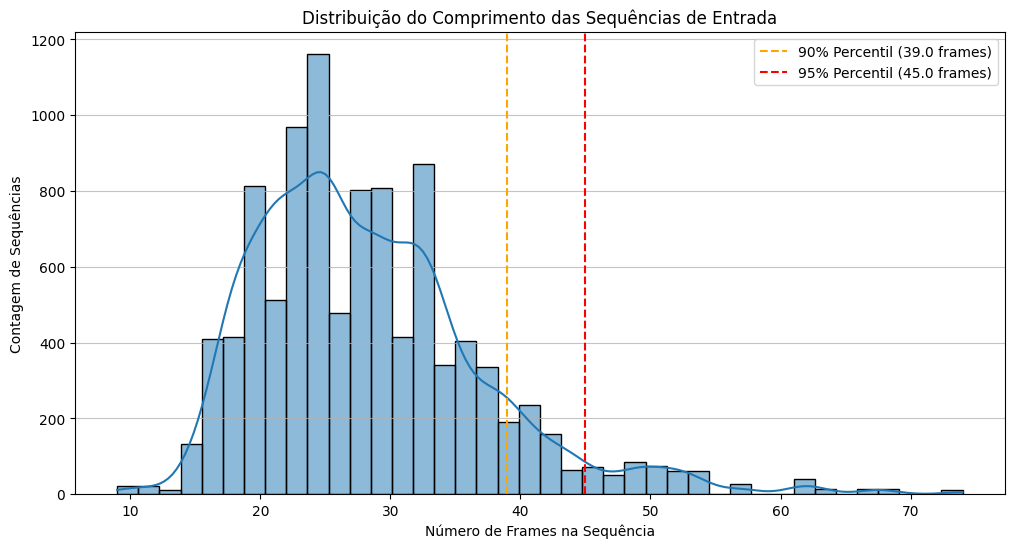


Iniciando o treinamento...


2025-10-04 20:40:08.017406: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 601351800 exceeds 10% of free system memory.
2025-10-04 20:40:09.006741: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 601351800 exceeds 10% of free system memory.


Epoch 1/100


2025-10-04 20:40:12.349599: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91301


1119/1119 ━━━━━━━━━━━━━━━━━━━━ 37s 30ms/step - loss: 30.2064 - root_mean_squared_error: 5.4960 - val_loss: 13.6269 - val_root_mean_squared_error: 3.6915 - learning_rate: 0.0010
Epoch 2/100
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - loss: 13.1833 - root_mean_squared_error: 3.6309 - val_loss: 12.7386 - val_root_mean_squared_error: 3.5691 - learning_rate: 0.0010
Epoch 3/100
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 32s 28ms/step - loss: 12.5673 - root_mean_squared_error: 3.5450 - val_loss: 12.3339 - val_root_mean_squared_error: 3.5120 - learning_rate: 0.0010
Epoch 4/100
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 32s 28ms/step - loss: 12.2613 - root_mean_squared_error: 3.5016 - val_loss: 12.3597 - val_root_mean_squared_error: 3.5156 - learning_rate: 0.0010
Epoch 5/100
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 32s 28ms/step - loss: 12.0838 - root_mean_squared_error: 3.4762 - val_loss: 11.9835 - val_root_mean_squared_error: 3.4617 - learning_rate: 0.0010
Epoch 6/100
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 32s 29ms/step - loss: 11

Treinamento concluído e modelos salvos.


In [19]:
import seaborn as sns

# Para uma análise completa, você poderia carregar e concatenar todos os 18 arquivos de input.
# Ex: df = load_data('./', range(1, 19), 'input')
df = pd.read_csv('./nfl-big-data-bowl-2026-prediction/train/input_2023_w01.csv')

print("Analisando o arquivo 'input_2023_w01.csv'...")

# 1. Agrupa os dados por cada sequência única e conta o número de frames
#    Uma sequência é definida pela trajetória de um jogador (nfl_id) em uma jogada (play_id).
sequence_lengths = df.groupby(['game_id', 'play_id', 'nfl_id']).size()

# 2. Calcula as estatísticas descritivas, incluindo os percentis mais importantes
stats = sequence_lengths.describe(percentiles=[.5, .75, .90, .95, .99]).round(2)

print("\n--- Análise do Comprimento das Sequências de Entrada ---")
print("\nEstatísticas Descritivas:")
print(stats)

# 3. Plotar um histograma para visualizar a distribuição
plt.figure(figsize=(12, 6))
sns.histplot(sequence_lengths, bins=40, kde=True)
plt.title('Distribuição do Comprimento das Sequências de Entrada')
plt.xlabel('Número de Frames na Sequência')
plt.ylabel('Contagem de Sequências')

# Adiciona linhas verticais para os percentis para fácil interpretação
plt.axvline(stats['90%'], color='orange', linestyle='--', label=f"90% Percentil ({stats['90%']} frames)")
plt.axvline(stats['95%'], color='red', linestyle='--', label=f"95% Percentil ({stats['95%']} frames)")

plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.savefig('sequence_length_distribution.png')
print("\nUm gráfico da distribuição foi salvo como 'sequence_length_distribution.png'")
print("Use este gráfico para tomar uma decisão informada sobre o seu `max_input_len`.")

Gráfico do histórico de treinamento salvo como 'training_history.png'


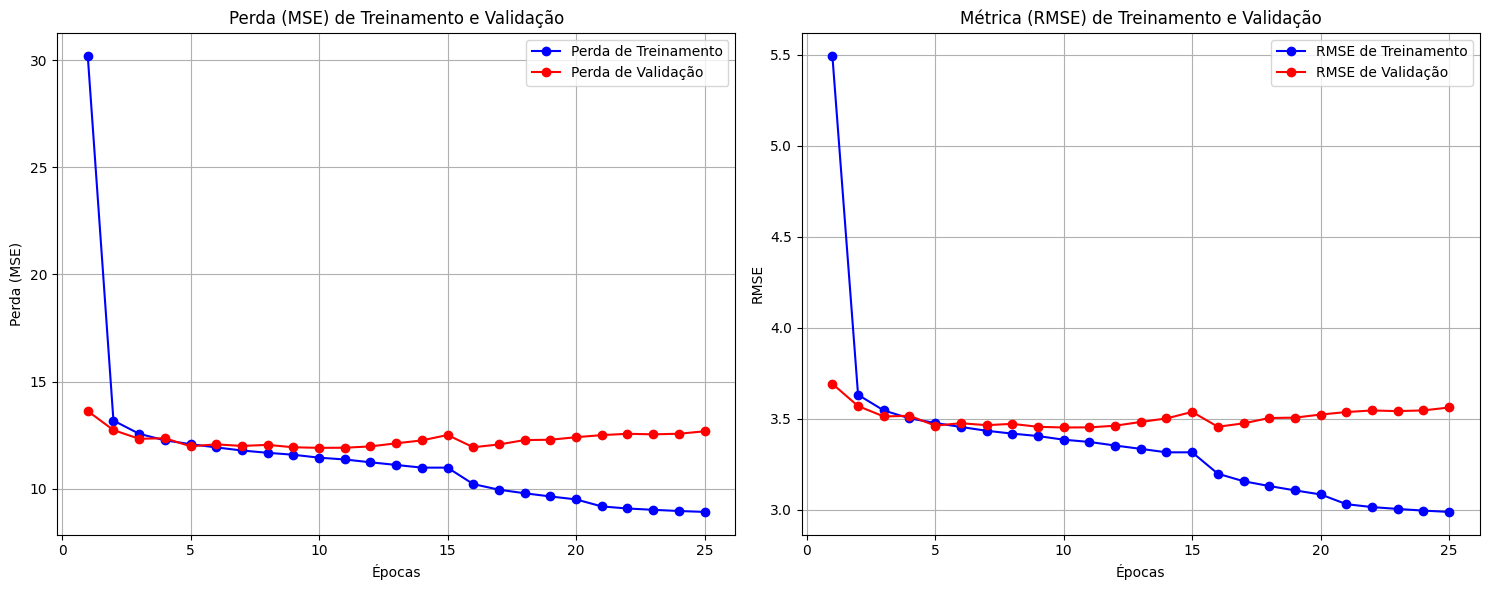

In [ ]:
plot_training_history(history)

# Train Data - Grid Search

In [ ]:
param_grid = {
    'LATENT_DIM': [128, 256, 512],
    'BATCH_SIZE': [64, 128],
    'LEARNING_RATE': [0.001, 0.0005],
    'DROPOUT_RATE': [0.2, 0.4, 0.6]
}

In [13]:
history = run_grid_search(param_grid, epochs=100)

Carregando dados pré-processados de 'processed_training_data.npz'...


Dados carregados com sucesso.

Iniciando Grid Search com 36 combinações.

--- Rodada 1/36 ---


TypeError: build_seq2seq_model() got an unexpected keyword argument 'dropout_rate'

In [ ]:
plot_training_history(history)